<h1 align=center>PRÁCTICA DEL MÓDULO DE NLP</h1>

<h3 align=center>ALUMNO: David Jiménez Vicente</h3>

<h2 align=center>Notebook 2 : Pipeline de preprocesado</h2>

En este caso usaré NLTK para las tareas de preprocessing.

In [1]:
# Para los datos
import random
import numpy as np
import pandas as pd

# Para exploración y preproc
from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist
import unicodedata
import re
from nltk.corpus import stopwords
from num2words import num2words
from nltk.stem import WordNetLemmatizer

# Para dibujar
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#### Vamos a continuar con el preprocesado y algunos análisis derivados, y al final pondré el pipeline. Debería ponerse al principio del documento por buenas prácticas, pero lo pondré al final para que se aprecie la progresión del ejercicio.

Empezaremos cargando el dataset derivado del primer proceso de limpieza del notebook 1

In [2]:
df_raw = pd.read_csv("ratings_raw.csv")
df_raw.head()

,review,sent
0,"I hesitated at first, but nabbed the kit on a ...",1
1,Plain and simple...some of the frets are not p...,0
2,"she loved it, won't stop playing Five Stars",1
3,Thank you Five Stars,1
4,I ordered this ukulele kit for my granddaughte...,1


In [3]:
df_raw.shape

(1429398, 2)

<h3 align=center><i>Etapa 2: Ingesta</i></h3>

De cara a optimizar el rendimiento y mejorar los modelos posteriores, voy a balancear las categorías del target ya. Primero averiguaré cuántos registros hay de cada sentimiento:

In [4]:
df_raw.sent.value_counts()

sent
1    1158776
0     270622
Name: count, dtype: int64

El máximo número para una clase es de unos 270000 reviews, así que me quedaré finalmente con 100000 de cada clase.

In [5]:
def sampleo(group, k=100000):
    min_len = min(df_raw.sent.value_counts())
    if min_len < k:
        k = min_len
    return group.sample(k)
df_bal = df_raw.groupby('sent').apply(sampleo).sample(frac=1).reset_index(drop=True)
df_bal

,review,sent
0,This is my second Souldier guitar strap and I ...,1
1,They're great thank you I'll be ordering more....,1
2,This unit failed after only 3 months of occasi...,0
3,"It was ok, not what I thought it was going to ...",0
4,Plays great... sounds great. Five Stars,1
...,...,...
199995,You are better off spending an additional $3 f...,0
199996,Dope. Works like a charm. Wonder do they make ...,1
199997,Works fine. Just wish it was a little lower pr...,0
199998,This practice pad is popular for good reason. ...,1


 Ahora separaré las features del target:

In [6]:
features_raw = df_bal["review"]
targets_raw = df_bal["sent"]

In [17]:
features_raw

0         This is my second Souldier guitar strap and I ...
1         They're great thank you I'll be ordering more....
2         This unit failed after only 3 months of occasi...
3         It was ok, not what I thought it was going to ...
4                   Plays great... sounds great. Five Stars
                                ...                        
199995    You are better off spending an additional $3 f...
199996    Dope. Works like a charm. Wonder do they make ...
199997    Works fine. Just wish it was a little lower pr...
199998    This practice pad is popular for good reason. ...
199999    I purchased this to teach a yoga class outside...
Name: review, Length: 200000, dtype: object

In [8]:
targets_raw.head()

0    1
1    1
2    0
3    0
4    1
Name: sent, dtype: int64

<h3 align=center><i>Etapa 3: Preprocesado</i></h3>

Nos quedaría la normalización aplicar stopwords, y revisión de resultados antes de pasar a los modelos.  
Empezamos con la normalización:

- Crearé una función para normalizar el texto:

In [18]:
def cleaner(sentence):
    
    
    # Normalizamos con unicodedata con el standard NFKD (transforma
    # caracteres compatibles con sus equivalentes compuestos (p. ej. la letra única "ñ", que se reemplaza por una letra
    # compuesta de dos caracteres, la "n" + una "~"), se pasa a minúsculas, y se vuelve a transformar eliminando
    # todo carácter que no sea una letra, quitando las composiciones anteriores NFKD (lo que eliminaría p. ej. la "~").
    sentence = unicodedata.normalize('NFKD', sentence).lower().encode('ascii', errors='ignore').decode('utf-8')
    
    # Ahora usamos regex para limpiar el resto de la frase y quitamos espacios en los extremos de la frase.
    # Concretamente, este REgEx sólo mantendrá caracteres alfanuméricos y secuencias de 1 sólo espacio.
    sentence = re.sub(r'[^\w\s]', '', sentence)
    sentence = re.sub(r' +', ' ', ' '.join([word for word in sentence.split()]))
    
    # Pasamos de números a palabras.
    sentence = ' '.join([word if not word.isdigit() else num2words(word, ordinal=False) for word in sentence.split(' ')])
    
    
    # Ahora eliminaremos los stopwords:
    stop_list = stopwords.words("english")
    sentence = ' '.join([word for word in sentence.split() if word not in stop_list])
    
    # Por último aplicaré lematización para reducir más las features a su raíz.
    lem = WordNetLemmatizer()
    sentence = ' '.join([lem.lemmatize(word) for word in sentence.split()])
    
    
    return sentence

In [19]:
# Comprobamos la función:
import time
start = time.time()
display(features_raw.apply(cleaner))
print(round(time.time()-start,3), "segundos")

0         second souldier guitar strap fan one beautiful...
1                 theyre great thank ill ordering five star
2         unit failed three month occasional use tried c...
3                  ok thought going didnt fit need two star
4                          play great sound great five star
                                ...                        
199995    better spending additional three genuine fende...
199996    dope work like charm wonder make long cord for...
199997        work fine wish little lower priced three star
199998    practice pad popular good reason use every day...
199999    purchased teach yoga class outside fifteen peo...
Name: review, Length: 200000, dtype: object

29.855 segundos


Ahora uniré features y targets momentaneamente para hacer de nuevo un análisis visual del resultado.

In [20]:
df_result = pd.concat([features_raw.apply(cleaner), targets_raw], axis=1)
df_result.head(20)

,review,sent
0,second souldier guitar strap fan one beautiful...,1
1,theyre great thank ill ordering five star,1
2,unit failed three month occasional use tried c...,0
3,ok thought going didnt fit need two star,0
4,play great sound great five star,1
5,work great five star,1
6,job efficient classy way set easy opening lawn...,1
7,pedal great size even smaller person fit one r...,1
8,recently purchased pedal thirty-five dollar po...,0
9,daughter us cello music sheet fold nicely come...,1


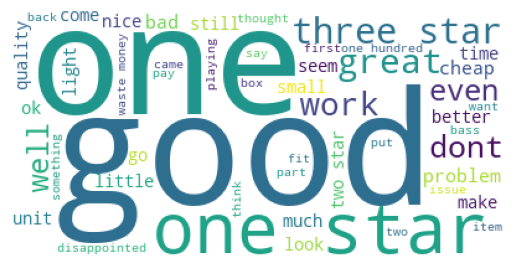

In [21]:
df_negs = df_result[df_result["sent"] == 0]
df_poss = df_result[df_result["sent"] == 1]

review_neg = []

for i,j in df_negs["review"].items():
    for z in j.split():
        review_neg.append(z + " ")
        
one_string_neg = "".join(review_neg)

wordcloud_neg = WordCloud(background_color = "white", max_words = 50).generate(one_string_neg)
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.show()

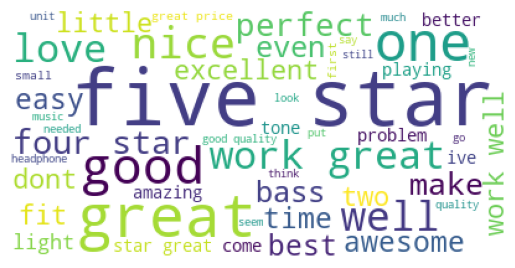

In [22]:
review_pos = []

for i,j in df_poss["review"].items():
    for z in j.split():
        review_pos.append(z + " ")
        
one_string_pos = "".join(review_pos)

wordcloud_pos = WordCloud(background_color = "white", max_words = 50).generate(one_string_pos)
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.show()

Vamos a incluir stopwords en el wordcloud que no aportan información porque se repiten mucho en ambas categorías, empezando por las negativas:

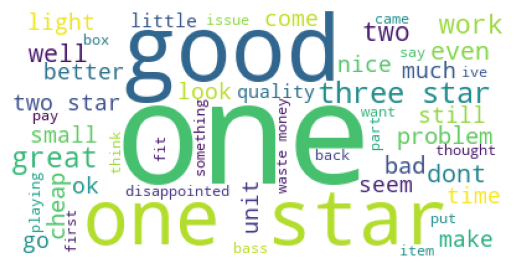

In [28]:
wordcloud_pos2 = WordCloud(background_color = "white", max_words = 50, stopwords=STOPWORDS.update(["thousand", "thousand.", "hundred", "guitar", "strap", "microphone", "instrument", "buy", "use", "used", "thing", "speaker", "headphones", "product", "case", "pedal", "string", "stand", "mic", "using", "got", "really", "sound", "way", "pick", "amp", "play", "cable", "bought", "need", "keyboard", "made", "set"])).generate(one_string_neg)
plt.imshow(wordcloud_pos2)
plt.axis("off")
plt.show()

Y continuamos con las positivas:

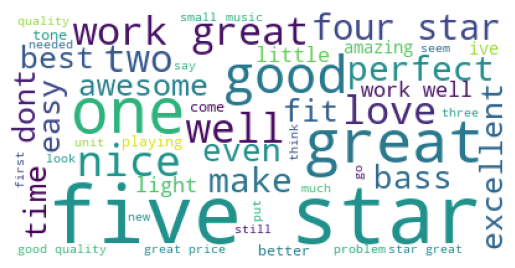

In [29]:
wordcloud_neg2 = WordCloud(background_color = "white", max_words = 50, stopwords=STOPWORDS.update(["thousand", "thousand.", "hundred", "guitar", "strap", "microphone", "instrument", "use", "buy", "used", "thing", "speaker", "headphones", "product", "case", "pedal", "string", "stand", "mic", "using", "got", "really", "sound", "way", "pick", "amp", "play", "cable", "bought", "need", "keyboard", "made", "set"])).generate(one_string_pos)
plt.imshow(wordcloud_neg2)
plt.axis("off")
plt.show()

Vemos una diferenciación mucho mayor en el vocabulario entre ambas categorías al eliminaf las palabras comunes, menos algunas como "good" o "work" que pueden ser dependientes del contexto, como "doesn't work" o "do work", o como "really good" o "not good", y que dejaremos para que sean featurizadas por los embeddings con contexto.  
Estos stopwords los añadiremos a continuación en el pipeline junto con la librería genérica de stopwords.

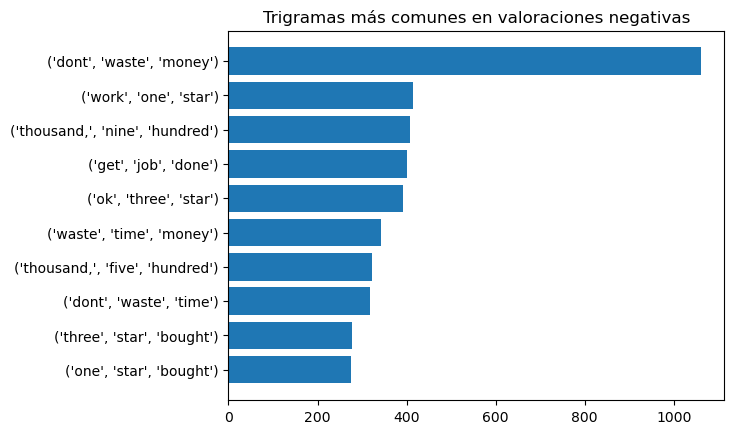

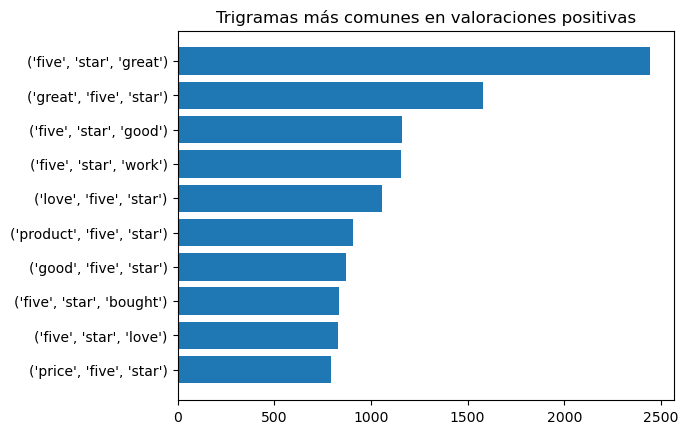

In [25]:
neg_trigrams_ = list(ngrams(one_string_neg.lower().split(), 3))
pos_trigrams_ = list(ngrams(one_string_pos.lower().split(), 3))
neg_tg_freq = FreqDist(neg_trigrams_)
pos_tg_freq = FreqDist(pos_trigrams_)
neg_tg_common = neg_tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in neg_tg_common]
tgs_f_ = [tg[1] for tg in neg_tg_common]
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

plt.barh(tgs_, tgs_f_)
plt.title('Trigramas más comunes en valoraciones negativas')
plt.show()

pos_tg_common = pos_tg_freq.most_common(10)
pos_tgs_ = [str(tg[0]) for tg in pos_tg_common]
pos_tgs_f_ = [tg[1] for tg in pos_tg_common]
pos_tgs_f_, pos_tgs_ = zip(*sorted(zip(pos_tgs_f_, pos_tgs_)))

plt.barh(pos_tgs_, pos_tgs_f_)
plt.title('Trigramas más comunes en valoraciones positivas')
plt.show()

Observamos un cambio radical el los trigramas y los WordClouds, estando en cada categoría mucho más relacionados entre sí los resultados. Se aprecia sobre todo en los trigramas, quedando claras afirmaciones como "no gastes dinero" o "no gastes tiempo" para las negativas, y "cinco estrellas" o "lo adoro" para las positivas.
Seguro que se puede mejorar con más tiempo y análisis exhaustivo, pero para armar un primer modelo Demo vale. Por lo tanto, usaré este Preproc en el Pipeline para el modelo.

<h3 align=center><i>Etapa 4: PIPELINE</i></h3>

In [32]:
# Para los datos
import random
import numpy as np
import pandas as pd

# Para exploración y preproc
from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist
import unicodedata
import re
from nltk.corpus import stopwords

# Para dibujar
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

def carga(file):
    """
    Returns a pandas DataFrame from the input file.
    Input = A .csv file. It has to have just to columns:
            · "review": string dtype, for features, the reviews themselves.
            · "sent": integer dtype,  for targets, the sentiment. 1 for possitive, 0 for negative.
    Output = Pandas DataFrame
    """
    df = pd.read_csv(file)
    return df

def sampler(group, k=100000):
    """
    Inputs a categorical data collection, and samples the same ammount of items for each category in the variable.
    If the number of "k" is bigger than the number of items for any of the categories in the sentiment variable, sets "k" as the minimum number
    of samples from all the categories.
    Input = "group" : Categorical data collection.
            "k": Integer, number of samples to extract. Default=100k
            If another k is desired, 
    """
    min_len = min(df.sent.value_counts())
    if min_len < k:
        k = min_len
    return group.sample(k)
    
    
def balancer(x):
    """
    Uses the sampler() function to select 
    """
    return x.groupby('sent').apply(sampler).sample(frac=1).reset_index(drop=True)


def cleaner(sentence):
    sentence = unicodedata.normalize('NFKD', sentence).lower().encode('ascii', errors='ignore').decode('utf-8')
    sentence = re.sub(r'[^\w\s]', ' ', sentence)
    sentence = re.sub(r' +', ' ', ' '.join([word for word in sentence.split()])).strip()
    sentence = ' '.join([word if not word.isdigit() else num2words(word, ordinal=False) for word in sentence.split(' ')])
    stop_list = stopwords.words("english")
    cust_stop = ["thousand", "thousand.", "hundred", "guitar", "strap", "microphone", "instrument", "use", "buy", "used", 
                 "thing", "speaker", "headphones", "product", "case", "pedal", "string", "stand", "mic", "using", "got", 
                 "really", "sound", "way", "pick", "amp", "play", "cable", "bought", "need", "keyboard", "made", "set"]
    stop_list.extend(cust_stop)
    sentence = ' '.join([word for word in sentence.split() if word not in stop_list]).strip()
    return sentence

def splitter(x):
    f = x["review"]
    t = x["sent"]
    return f, t


    
def preproceso(x):
    """
    Pipeline function using the functions defined above.
    Requires the initial data to be stored in a pandas dataframe with two columns: "review" and "sent".
    """
    import time
    
    global df
    global df_bal
    
    start = time.time()
    
    print("Cargando datos... / Loading...")
    df = carga(x)
    print("Tamaño del Data Frame:", df.shape)
    
    print("\nBalanceo de clases... / Balancing categories...")
    df_bal = balancer(df)
    
    print("\nTokenizando y normalizando... / Tokenization and normalization...")
    df_bal["review"] = df_bal["review"].apply(cleaner)
    df_bal = df_bal[df_bal.review != ""]
    df_bal = df_bal.reset_index(drop=True)
    
    print("\nSeparando features de targets... / Setting features and targets apart...")
    f_raw, t_raw = splitter(df_bal)
    print(f"\nProceso completado en / Completed in {round(time.time()-start, 3)} segundos / seconds\n")
    
    f_raw.to_csv("features.csv", index=False)
    t_raw.to_csv("targets.csv", index=False)
    
    return f_raw, t_raw


features, targets = preproceso("ratings_raw.csv")


Cargando datos... / Loading...
Tamaño del Data Frame: (1429398, 2)

Balanceo de clases... / Balancing categories...

Tokenizando y normalizando... / Tokenization and normalization...

Separando features de targets... / Setting features and targets apart...

Proceso completado en / Completed in 26.279 segundos / seconds



Comprobamos el resultado del pipeline:

In [33]:
pd.concat([features.head(20), targets.head(20)], ignore_index=True, axis=1)

,0,1
0,even download dj program get error sixteen eve...,0
1,brother christmas loved perfect present,1
2,experienced field music creation mainly audix ...,1
3,wish someone written review item plastic toy l...,0
4,sounds great easy glad pre ordered wait worthw...,1
5,one break faster american sticks two order say...,0
6,disappointed strings people praise chromes muc...,0
7,two years ago speakers much research delighted...,0
8,high hopes arrived shocked see required power ...,0
9,son knew install properly would perfect ibanez...,1
